# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260114.xlsx"
code = "7011"
# code = "72#03"
# code = "83#06"
dict_setting = load_setting(res, code)
#dict_setting["PERIOD_MA_1"] = 30
#dict_setting["PERIOD_MA_2"] = 300
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/14
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 170
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-14 09:16:20.757154942  7011  売建  4577   100     NaN      
1      2 2026-01-14 09:19:24.466943026  7011  買埋  4602   100 -2500.0      
2      3 2026-01-14 09:19:43.481167078  7011  買建  4602   100     NaN      
3      4 2026-01-14 09:29:34.176779032  7011  売埋  4612   100  1000.0      
4      5 2026-01-14 09:29:35.183406115  7011  売建  4612   100     NaN      
5      6 2026-01-14 09:36:19.513462066  7011  買埋  4615   100  -300.0      
6      7 2026-01-14 10:02:54.719801903  7011  買建  4633   100     NaN      
7      8 2026-01-14 10:12:53.466048002  7011  売埋  4638   100   500.0      
8      9 2026-01-14 10:21:20.096019983  7011  買建  4638   100     NaN      
9     10 2026-01-14 10:34:04.435461044  7011  売埋  4641   100   300.0      
10    11 2026-01-14 10:34:05.441452026  7011  売建  4641   100     NaN      
11    12 2026-01-14 10:40:40.833502054  7011  買埋  4644   100  -300.0      
12    13 2026-01-14 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=9)],
    "累積損益": [0.0],
})

end_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
    "累積損益": [pl.iloc[-1]],
})

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row],
    ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-14 09:00:00.000000000       0.0
2026-01-14 09:16:20.757154942       0.0
2026-01-14 09:19:24.466943026   -2500.0
2026-01-14 09:19:43.481167078   -2500.0
2026-01-14 09:29:34.176779032   -1500.0
2026-01-14 09:29:35.183406115   -1500.0
2026-01-14 09:36:19.513462066   -1800.0
2026-01-14 10:02:54.719801903   -1800.0
2026-01-14 10:12:53.466048002   -1300.0
2026-01-14 10:21:20.096019983   -1300.0
2026-01-14 10:34:04.435461044   -1000.0
2026-01-14 10:34:05.441452026   -1000.0
2026-01-14 10:40:40.833502054   -1300.0
2026-01-14 10:40:41.837982893   -1300.0
2026-01-14 10:46:27.012353897   -1700.0
2026-01-14 11:05:20.148251057   -1700.0
2026-01-14 11:12:24.459594011   -2200.0
2026-01-14 11:15:20.160583973   -2200.0
2026-01-14 11:23:45.631506920   -2100.0
2026-01-14 12:30:41.770925999   -2100.0
2026-01-14 12:35:04.714392900   -4000.0
2026-01-14 12:35:05.710421085   -4000.0
2026-01-14 12:40:07.666377068   -4800.0
2026-01-14 12:47:44.899831057   -4800.0
2026-01-14 12:51:44.580913067   -52

output/2026/01/14/7011_trend_profit.png


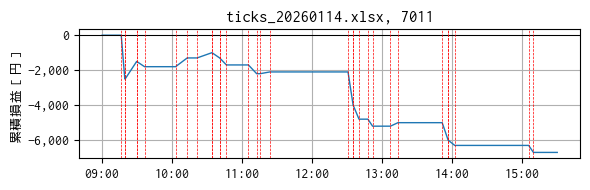

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1       ma2    slope1  rr  \
2026-01-14 09:00:03  1.768349e+09   4510  4510.000000  4510.000  0.000000   0   
2026-01-14 09:00:04  1.768349e+09   4510  4510.000000  4510.000  0.000000   0   
2026-01-14 09:00:05  1.768349e+09   4513  4511.000000  4511.000  0.600000   3   
2026-01-14 09:00:06  1.768349e+09   4513  4511.500000  4511.500  0.571429   3   
2026-01-14 09:00:07  1.768349e+09   4522  4513.600000  4513.600  1.083333  12   
...                           ...    ...          ...       ...       ...  ..   
2026-01-14 15:24:45  1.768372e+09   4701  4699.823529  4700.110  0.000000   4   
2026-01-14 15:24:46  1.768372e+09   4701  4699.823529  4700.102  0.000000   4   
2026-01-14 15:24:47  1.768372e+09   4701  4699.829412  4700.094  0.001961   4   
2026-01-14 15:24:48  1.768372e+09   4701  4699.835294  4700.086  0.003725   4   
2026-01-14 15:24:49  1.768372e+09   4700  4699.829412  4700.076  0.001176   4   

                   

In [8]:
df_tech["slope1"].describe()

count    19428.000000
mean         0.038337
std          0.049324
min          0.000000
25%          0.011765
50%          0.025098
75%          0.049412
max          2.020952
Name: slope1, dtype: float64

output/2026/01/14/7011_trend_technical.png


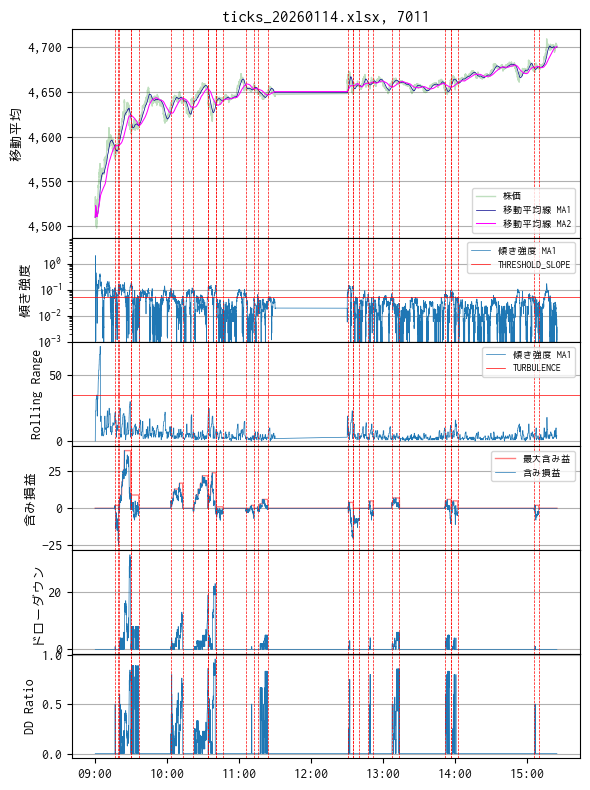

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 6
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

ax[4].plot(df_tech["drawdown"], linewidth=0.5)
ax[4].set_ylabel("ドローダウン")

ax[5].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[5].set_ylabel("DD Ratio")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/14/7011_hist_slope.png


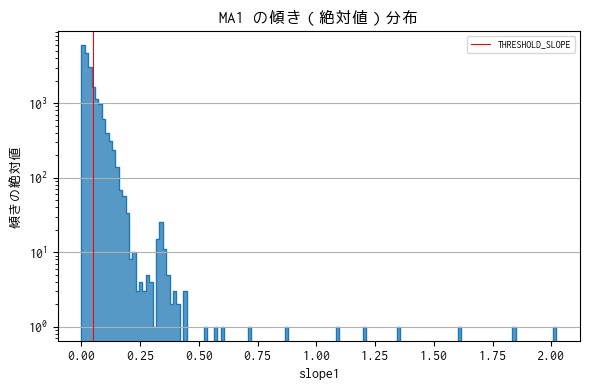

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/14/7011_hist_rr.png


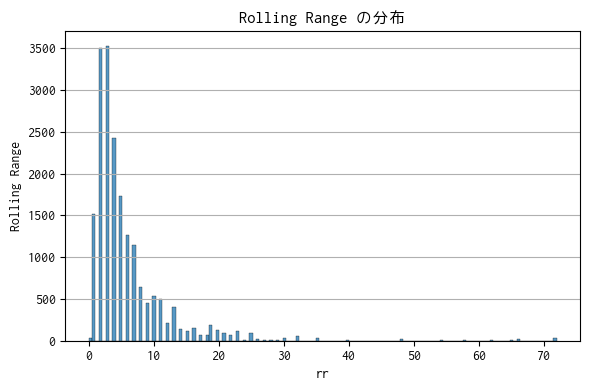

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1   建玉
2026-01-14 09:00:03    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...
2026-01-14 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-14 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0

[19428 rows x 6 columns]


output/2026/01/14/7011_trend_obs.png


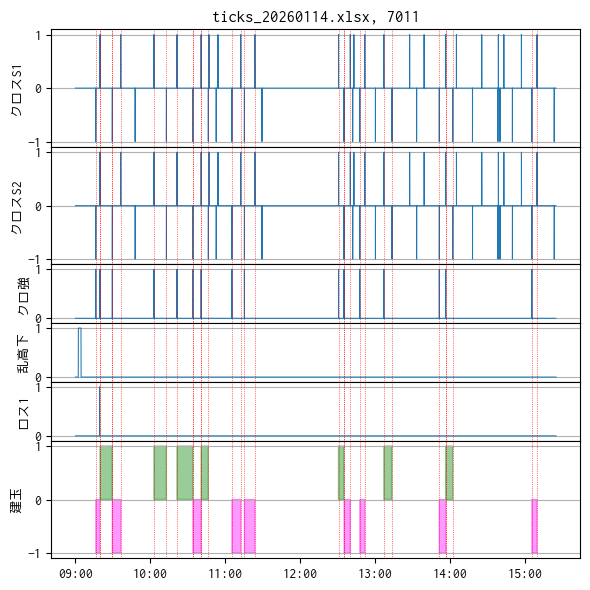

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()